In [48]:
# !pip install 'numpy>=1.20,<1.24'
# # verzija niz od 1.24 zbog problema s numpy float

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import xmltodict
from rdkit import Chem
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

### 1. Učitavanje podataka

In [2]:
# path = "/content/drive/My Drive/kemoinf/data/dopamine.csv"
path = "./data/dopamine.csv"

In [3]:
data = pd.read_csv(path, index_col=0)
data

,ChEMBL_ID,pIC50
0,CHEMBL303519,5.01
1,CHEMBL292943,7.30
2,CHEMBL61682,7.60
3,CHEMBL64487,6.44
4,CHEMBL64597,6.52
...,...,...
474,CHEMBL3805434,7.42
475,CHEMBL3805327,7.23
476,CHEMBL3805262,5.80
477,CHEMBL3805515,6.70


### 2. Dohvaćanje SMILES zapisa

Retrieve SMILES representation for each molecule using the ChEMBL REST API through your Python environment.

Make SMILES canonical by using rdkit Python package.

In [4]:
smiles = []
for mol_id in data.ChEMBL_ID:
    response = requests.get(f'https://www.ebi.ac.uk/chembl/api/data/molecule/{mol_id}')
    smiles.append(Chem.CanonSmiles(xmltodict.parse(response.text)['molecule']['molecule_structures']['canonical_smiles']))
data['smiles'] = smiles
# data.to_csv('./data/temp.csv', index=False)

In [5]:
data

,ChEMBL_ID,pIC50,smiles
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1
...,...,...,...
474,CHEMBL3805434,7.42,CNC(=O)c1cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)cc(C...
475,CHEMBL3805327,7.23,CNC(=O)c1ccc(Cl)c(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC...
476,CHEMBL3805262,5.80,CNC(=O)c1cc(F)cc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1
477,CHEMBL3805515,6.70,CNC(=O)c1cccc(OCCCCN2CCN(c3cccc(Cl)c3Cl)CC2)c1OC


### 3. Računanje moleklularnih deskriptora
Calculate molecular descriptors by using Mordred Python package or some other available molecular descriptor calculator. Use all available 0D, 1D, 2D and 3D molecular descriptors


- 0D descriptors: Molecular weight, atom count, etc.
- 1D descriptors: Simple structural features
- 2D descriptors: Topological and connectivity-based descriptors
- 3D descriptors: Geometric and spatial characteristics

https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem
from mordred import Calculator, descriptors
import pandas as pd
import tempfile
import os

def generate_3d_conformer(mol):
    """
    Generate 3D conformer for a molecule.
    """
    mol = Chem.AddHs(mol)
    success = AllChem.EmbedMolecule(mol, randomSeed=42, useRandomCoords=True)
    if success == -1:
        return None
    try:
        AllChem.MMFFOptimizeMolecule(mol)
    except:
        try:
            AllChem.UFFOptimizeMolecule(mol)
        except:
            return None
    return mol

def smiles_to_sdf(df, smiles_col='smiles', id_col='ChEMBL_ID'):
    """
    Convert SMILES to SDF file with 3D conformers.
    """
    mols = []
    valid_indices = []

    for idx, row in df.iterrows():
        mol = Chem.MolFromSmiles(row[smiles_col])
        if mol is not None:
            mol_3d = generate_3d_conformer(mol)
            if mol_3d is not None:
                # Add properties to the molecule
                for col in df.columns:
                    if col != smiles_col:
                        mol_3d.SetProp(col, str(row[col]))
                mols.append(mol_3d)
                valid_indices.append(idx)
            else:
                print(f"Failed to generate 3D conformer for molecule {row[id_col]}")

    temp_sdf = tempfile.NamedTemporaryFile(suffix='.sdf', delete=False)
    writer = Chem.SDWriter(temp_sdf.name)

    for mol in mols:
        writer.write(mol)
    writer.close()

    return temp_sdf.name, valid_indices

def calculate_mordred_descriptors(sdf_file):
    """
    Calculate all Mordred descriptors including 3D.
    """
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [mol for mol in Chem.SDMolSupplier(sdf_file) if mol is not None]
    df_descriptors = calc.pandas(mols)
    return df_descriptors

print("Converting SMILES to 3D structures and generating SDF file...")
sdf_file, valid_indices = smiles_to_sdf(df=data)

try:
    print("Calculating descriptors...")
    descriptors_df = calculate_mordred_descriptors(sdf_file)

    # Combine the descriptors with the original data
    valid_data = data.iloc[valid_indices].reset_index(drop=True)
    final_dataset = pd.concat([valid_data.reset_index(drop=True), descriptors_df.reset_index(drop=True)], axis=1)

    # Save the complete dataset
    final_dataset.to_csv('molecular_features.csv', index=False)

    # Print summary statistics
    print("\nDataset Summary:")
    print(f"Total molecules processed: {len(final_dataset)}")
    print(f"Total features generated: {len(final_dataset.columns)}")

finally:
    # Clean up temporary file
    os.remove(sdf_file)

Converting SMILES to 3D structures and generating SDF file...
Calculating descriptors...


  3%|▎         | 14/479 [00:03<01:19,  5.83it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 15%|█▍        | 70/479 [00:06<00:22, 18.03it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 18%|█▊        | 88/479 [00:08<00:33, 11.84it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 37%|███▋      | 176/479 [00:17<00:34,  8.82it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 72%|███████▏  | 343/479 [00:32<00:07, 18.57it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 72%|███████▏  | 346/479 [00:35<00:07, 18.57it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 74%|███████▎  | 353/479 [00:38<00:26,  4.69it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 77%|███████▋  | 370/479 [00:38<00:13,  7.84it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 89%|████████▊ | 425/479 [00:47<00:12,  4.27it/s]

c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
c:\Users\afs\anaconda3\envs\oldPy36\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 479/479 [00:50<00:00,  9.51it/s]



Dataset Summary:
Total molecules processed: 479
Total features generated: 1829


In [7]:
final_dataset.head()

,ChEMBL_ID,pIC50,smiles,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CHEMBL303519,5.01,c1cnc(N2CCN(Cc3cccc4c3Cc3ccccc3-4)CC2)nc1,21.011003,14.920944,0,1,35.8356,2.50488,4.869,...,10.266776,75.682997,342.184447,7.128843,1797,42,144.0,173.0,5.38889,5.638889
1,CHEMBL292943,7.30,COc1ccc(-c2cccc(CN3CCN(c4ncccn4)CC3)c2)cc1,21.132323,14.720991,0,1,36.5224,2.36015,4.72031,...,10.083765,61.954496,360.195011,7.062647,2172,40,140.0,162.0,6.52778,6.055556
2,CHEMBL61682,7.60,Fc1ccc(-c2cncc(CN3CCN(c4ccccc4F)CC3)c2)cc1,21.310663,15.088212,0,1,35.8117,2.37017,4.74033,...,10.141362,62.103563,365.170354,7.607716,2130,41,142.0,165.0,7.13889,5.916667
3,CHEMBL64487,6.44,COc1ccccc1-c1cccc(CN2CCN(c3ncccn3)CC2)c1,21.091883,15.171089,0,1,36.5285,2.37851,4.75702,...,10.117429,62.012532,360.195011,7.062647,2096,41,140.0,163.0,6.52778,6.083333
4,CHEMBL64597,6.52,c1cnc(N2CCN(Cc3cccc(-c4ccsc4)c3)CC2)nc1,19.011003,14.059124,0,1,32.5796,2.35661,4.69809,...,9.949655,71.503368,336.140868,7.639565,1532,33,126.0,146.0,5.16667,5.305556


### 4. Čišćenje podataka
Clean the transformed data of missing values and outliers. Remove duplicates.

- Nema duplikata.
- After generating all descriptors for each molecule, we removed descriptors with non-numerical values (e.g., containing strings or NA values) and descriptors with matching values across most (
95%) molecules. (https://www.sciencedirect.com/science/article/pii/S0016236122006950#sec3)

In [14]:
def prepare_features(descriptors_df):
    """
    Clean and prepare descriptors for machine learning while preserving specified columns.
    """
    # Columns to preserve
    string_columns_to_preserve = ['ChEMBL_ID', 'smiles', 'pIC50']

    # Separate preserved columns
    preserved_columns = descriptors_df[string_columns_to_preserve]

    # Work on the remaining numeric columns
    numeric_df = descriptors_df.drop(columns=string_columns_to_preserve, errors='ignore')

    # Convert all to numeric, replacing non-numeric with NaN
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

    # Remove columns with any NaN values
    numeric_df = numeric_df.dropna(axis=1)

    # Remove columns with constant or near-constant values across 95% of rows
    variability_thresh = 0.05 * len(numeric_df)
    numeric_df = numeric_df.loc[:, numeric_df.nunique() > variability_thresh]

    # Combine preserved columns back with cleaned numeric data
    final_df = pd.concat([preserved_columns.reset_index(drop=True), numeric_df.reset_index(drop=True)], axis=1)

    return final_df

In [15]:
final_dataset = prepare_features(final_dataset)
final_dataset['smiles'].duplicated().sum()

0

In [9]:
null_counts = final_dataset.isnull().sum()
columns_with_nulls = null_counts[null_counts != 0]
print(columns_with_nulls)

Series([], dtype: int64)


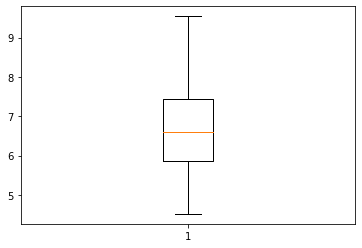

In [10]:
# boxplot značajke koju bismo trebali predvidjeti
# nema outliera
plt.boxplot(final_dataset['pIC50'])
plt.show()

In [17]:
final_dataset['pIC50'].describe()

count    479.000000
mean       6.698689
std        1.070454
min        4.520000
25%        5.865000
50%        6.600000
75%        7.450000
max        9.540000
Name: pIC50, dtype: float64

In [16]:
final_dataset.shape

(479, 844)

### 5. Feature analysis

**Simple correlation analysis with pIC50 feature**

In [63]:
# # Columns to preserve
# preserved_columns = ['ChEMBL_ID', 'smiles', 'pIC50']

# # Identify columns to compute correlations for
# numeric_columns = [col for col in final_dataset.columns if col not in preserved_columns]

# # Create a feature correlation matrix with pIC50
# correlations = pd.DataFrame({
#     'feature': numeric_columns,
#     'correlation_with_pIC50': [
#         final_dataset[col].corr(final_dataset['pIC50']) for col in numeric_columns
#     ]
# })

# # Sort correlations by absolute value
# correlations = correlations.sort_values('correlation_with_pIC50', key=abs, ascending=False)

# # Display the top 20 most correlated features
# print("\nTop 20 most correlated features with pIC50:")
# print(correlations.head(20))

**Removing features that are highly correlated between themselves**

**Recursive Feature Elimination (RFE) with an ensemble model estimator (Random Forest Regressor)**

In [64]:
# X = final_dataset.drop(['pIC50', 'ChEMBL_ID', 'smiles'], axis=1)
# y = final_dataset['pIC50']

In [65]:
# print(X.shape)
# correlation_matrix = X.corr(method='spearman')

# upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# # Find features with correlation > 0.85
# high_correlation_features = [column for column in upper.columns if any(upper[column] > 0.85)]

# # Drop highly correlated features
# filtered_dataset = X.drop(columns=high_correlation_features)
# print(filtered_dataset.shape)

In [66]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.feature_selection import RFECV
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(filtered_dataset)

# # Implement RFECV
# rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
# rfecv = RFECV(
#     estimator=rf_model,
#     step=1,
#     cv=5,  # 5-fold cross-validation
#     scoring="r2",  # Use R^2 as the scoring metric
#     n_jobs=-1,
#     min_features_to_select=20
# )

# # Fit RFECV to the filtered dataset
# rfecv.fit(X_scaled, y)

# # Identify selected features
# selected_features = filtered_dataset.columns[rfecv.support_]
# print(f"\nNumber of features selected by RFECV: {len(selected_features)}")
# print(f"Selected features:\n{selected_features.tolist()}")

# # Filter the dataset to keep only the selected features
# df_feature_selection = filtered_dataset[selected_features]
# print(f"Shape of the final dataset: {df_feature_selection.shape}")

### 6. Skaliranje podatka

Define and initialize scaler by using Scikit-learn Python package. Scale the data appropriately.

- https://scikit-learn.org/1.5/modules/preprocessing.html -> trebalo bi proučiti i odabrati scaler na temelju značajki (?)

In [20]:
final_dataset.describe()

,pIC50,ABC,ABCGG,nAtom,nHeavyAtom,nH,nC,ATS0dv,ATS1dv,ATS2dv,...,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2
count,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,...,479.000000,479.000000,479.000000,479.000000,479.000000,4.790000e+02,479.000000,479.000000,479.000000,479.000000
mean,6.698689,23.157321,17.152207,57.528184,29.791232,27.736952,23.112735,368.222401,367.144251,508.590366,...,4.798601,10.231156,75.075927,430.496542,7.542662,7.116948e+08,46.912317,155.344468,182.386221,6.583884
std,1.070454,7.384249,3.919125,18.172774,9.231917,9.385832,7.339626,130.921778,128.549108,198.647365,...,3.172723,0.324720,11.899348,127.193141,0.827723,3.283589e+09,17.412802,50.334907,60.357400,2.006059
min,4.520000,7.847124,7.263853,19.000000,10.000000,8.000000,8.000000,103.777778,99.111111,79.555556,...,0.000000,8.945463,41.621454,135.068414,5.897961,1.080000e+02,11.000000,50.000000,55.000000,2.194444
25%,5.865000,18.387101,14.872417,47.000000,24.000000,23.000000,19.000000,276.802469,281.555556,383.666667,...,0.000000,10.026146,68.041735,343.147253,7.009979,1.309500e+03,37.000000,124.000000,147.000000,5.222222
50%,6.600000,22.086719,16.403560,55.000000,28.000000,26.000000,22.000000,342.493827,340.111111,457.000000,...,6.555357,10.197462,72.883561,419.116732,7.467409,2.995000e+03,44.000000,148.000000,172.000000,6.277778
75%,7.450000,25.673157,18.442709,62.000000,33.000000,29.000000,26.000000,411.802469,410.055556,558.000000,...,6.985642,10.375770,81.266283,477.183605,7.978550,4.668500e+03,51.000000,172.000000,201.000000,7.361111
max,9.540000,64.086466,38.805484,153.000000,81.000000,82.000000,60.000000,1065.209877,1088.222222,1503.333333,...,8.188967,11.415213,131.291674,1142.513631,11.855608,2.800000e+10,146.000000,434.000000,514.000000,17.611111


In [35]:
from sklearn import preprocessing

scaled_df = final_dataset.copy()

scaler = preprocessing.MinMaxScaler()
for col in scaled_df:
    if pd.api.types.is_numeric_dtype(scaled_df[col]):
        scaled_df[col] = scaler.fit_transform(np.array(scaled_df[col]).reshape(-1, 1))

scaled_df.describe()
final_dataset = scaled_df.copy()

### 6. Splitting
Split the preprocessed dataset into subset for training and subset for testing in ratio 75:25. If using deep learning, split into subset for validation as well (ratio 70:15:15)

In [36]:
train, test = train_test_split(final_dataset, test_size=0.25)

train_DL, test_DL = train_test_split(final_dataset, test_size=0.3)
validate_DL, test_DL = train_test_split(test_DL, test_size=0.5)

train.to_pickle("./data/train.pkl")
test.to_pickle("./data/test.pkl")
train_DL.to_pickle("./data/train_DL.pkl")
test_DL.to_pickle("./data/test_DL.pkl")
validate_DL.to_pickle("./data/validate_DL.pkl")